# Rick Images Generator Interactive Demo

This notebook provides an interactive interface to generate images of Rick Sanchez using the pre-trained GAN model. You can explore the latent space and create unique Rick images with real-time controls.

In [1]:
# Install required packages
%pip install torch torchvision matplotlib ipywidgets

import torch
import torch.nn as nn
import torchvision.utils as vutils
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output
import random
from datetime import datetime

Note: you may need to restart the kernel to use updated packages.


## Loading Dependencies and Setup

First, we'll define the GAN architecture that was used for training, so we can load our pre-trained model.

In [2]:
# Check for CUDA availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Configuration parameters
nz = 100  # Size of latent vector (noise)
ngf = 64  # Size of feature maps in generator
nc = 3    # Number of channels in images (RGB)
image_size = 64  # Size of the generated images

# Set random seed for reproducibility
random_seed = 999
random.seed(random_seed)
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(random_seed)

Using device: cpu


## Generator Architecture

We need to define the generator architecture to match the one used during training.

In [3]:
class Generator(nn.Module):
    def __init__(self, ngpu=1):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

## Load Pre-trained Generator Model

Now we'll load the pre-trained model. Make sure you've run the main training notebook first.

In [4]:
# Initialize generator
netG = Generator().to(device)

# Load the saved model parameters
try:
    # Path to the pre-trained model
    model_path = "models/rick_generator_model.pth" 
    
    # Check if model exists
    if os.path.exists(model_path):
        netG.load_state_dict(torch.load(model_path, map_location=device))
        print("Pre-trained generator loaded successfully!")
    else:
        print("Model file not found! Using an untrained model which will produce random noise.")
        print("Please run the training notebook first to generate a model.")
except Exception as e:
    print(f"Error loading model: {e}")
    print("Continuing with untrained generator (will produce random noise)")

# Set the model to evaluation mode
netG.eval()

Model file not found! Using an untrained model which will produce random noise.
Please run the training notebook first to generate a model.


Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

## Interactive Generator Controls

Let's create interactive controls to manipulate the latent space and generate different Rick images.

Image generated in 0.02 seconds


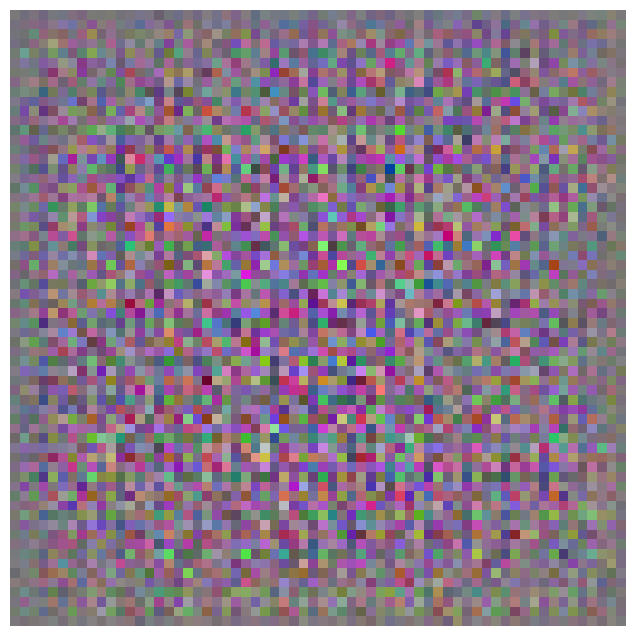

In [5]:
import time

# Function to generate an image from a latent vector
def generate_image(latent_vector):
    with torch.no_grad():
        start = time.time()
        latent_vector_reshaped = latent_vector.view(1, nz, 1, 1).to(device)
        fake_img = netG(latent_vector_reshaped).detach().cpu()
        end = time.time()
        print(f"Image generated in {end - start:.2f} seconds")
        return fake_img

# Function to display an image
def display_image(img):
    plt.figure(figsize=(8, 8))
    plt.axis("off")
    plt.imshow(np.transpose(vutils.make_grid(img, padding=2, normalize=True), (1, 2, 0)))
    plt.show()

# Initial random latent vector
fixed_noise = torch.randn(1, nz, 1, 1, device=device)
random_vector = fixed_noise.view(-1).detach().cpu()

# Generate and display an initial image
initial_img = generate_image(random_vector)
display_image(initial_img)

## Real-time Image Generation

Create an interactive interface to modify the latent space vectors directly.

In [6]:
# Create sliders for the first 10 dimensions of the latent space (for simplicity)
sliders = []
for i in range(10):
    slider = widgets.FloatSlider(
        value=random_vector[i].item(),
        min=-3.0,
        max=3.0,
        step=0.1,
        description=f'Dim {i+1}:',
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='.1f',
    )
    sliders.append(slider)

# Create a function to generate images when sliders change
output = widgets.Output()

def on_slider_change(change):
    with output:
        clear_output(wait=True)
        # Update the vector with slider values
        for i, slider in enumerate(sliders):
            if i < len(random_vector):
                random_vector[i] = slider.value
        
        # Generate and display the image
        img = generate_image(random_vector)
        display_image(img)

# Register the callback with each slider
for slider in sliders:
    slider.observe(on_slider_change, names='value')

# Create a button to generate a new random vector
def on_random_button_click(b):
    new_vector = torch.randn(nz)
    for i, slider in enumerate(sliders):
        if i < len(new_vector):
            slider.value = new_vector[i].item()

random_button = widgets.Button(description="Random Vector")
random_button.on_click(on_random_button_click)

# Create a button to save the current image
def on_save_button_click(b):
    with output:
        # Create a directory for saved images if it doesn't exist
        save_dir = "generated_images"
        os.makedirs(save_dir, exist_ok=True)
        
        # Generate filename with timestamp
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"{save_dir}/rick_generated_{timestamp}.png"
        
        # Generate the image
        img = generate_image(random_vector)
        
        # Save the image
        vutils.save_image(img, filename, normalize=True)
        print(f"Image saved to {filename}")

save_button = widgets.Button(description="Save Image")
save_button.on_click(on_save_button_click)

# Display the controls
controls = widgets.VBox([widgets.HBox([random_button, save_button])] + sliders)
display(controls, output)

# Generate initial image in the output area
with output:
    img = generate_image(random_vector)
    display_image(img)

Output()

## Latent Space Interpolation

Let's create tools to interpolate between different points in the latent space.

In [ ]:
# Function to interpolate between two latent vectors and display the result as an animation
def interpolate_vectors(z1, z2, steps=10):
    # Create interpolation points
    alphas = np.linspace(0, 1, steps)
    interpolated_images = []
    
    for alpha in alphas:
        z_interp = z1 * (1 - alpha) + z2 * alpha
        with torch.no_grad():
            img = generate_image(z_interp)
            interpolated_images.append(img)
    
    return interpolated_images

# Generate two random points in latent space
point1 = torch.randn(nz)
point2 = torch.randn(nz)

# Create interpolation slider
interpolation_slider = widgets.FloatSlider(
    value=0.0,
    min=0.0,
    max=1.0,
    step=0.05,
    description='Interpolate:',
    continuous_update=False
)

interp_output = widgets.Output()

def on_interpolation_slider_change(change):
    with interp_output:
        clear_output(wait=True)
        alpha = change['new']
        z_interp = point1 * (1-alpha) + point2 * alpha
        img = generate_image(z_interp)
        display_image(img)

interpolation_slider.observe(on_interpolation_slider_change, names='value')

# Button to generate new random points
def on_new_points_button_click(b):
    global point1, point2
    point1 = torch.randn(nz)
    point2 = torch.randn(nz)
    interpolation_slider.value = 0.0

new_points_button = widgets.Button(description="New Random Points")
new_points_button.on_click(on_new_points_button_click)

# Display the interpolation controls
display(widgets.VBox([
    widgets.HTML("<h3>Latent Space Interpolation</h3>"),
    widgets.HBox([interpolation_slider, new_points_button]),
    interp_output
]))

# Show initial interpolation
with interp_output:
    img = generate_image(point1)
    display_image(img)

## Batch Generation and Analysis

Let's generate a batch of images to analyze the diversity and quality of our generator.

In [8]:
# Generate a grid of multiple images
def generate_image_grid(num_images=25, nrow=5):
    noise = torch.randn(num_images, nz, 1, 1, device=device)
    with torch.no_grad():
        fake_batch = netG(noise).detach().cpu()
    
    grid = vutils.make_grid(fake_batch, nrow=nrow, padding=2, normalize=True)
    plt.figure(figsize=(12, 12))
    plt.axis("off")
    plt.title(f"Grid of {num_images} Generated Rick Images")
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.show()
    
    return fake_batch

# Button to generate an image grid
generate_grid_button = widgets.Button(description="Generate Image Grid")
grid_size_slider = widgets.IntSlider(
    value=25,
    min=4,
    max=64,
    step=1,
    description='Grid Size:',
    continuous_update=False
)

grid_output = widgets.Output()

def on_generate_grid_button_click(b):
    with grid_output:
        clear_output(wait=True)
        n = grid_size_slider.value
        nrow = int(np.sqrt(n))
        _ = generate_image_grid(n, nrow)

generate_grid_button.on_click(on_generate_grid_button_click)

# Display the grid controls
display(widgets.VBox([
    widgets.HTML("<h3>Generate Multiple Images</h3>"),
    widgets.HBox([grid_size_slider, generate_grid_button]),
    grid_output
]))

## Export Generated Images

Let's create functionality to export our generated images in different sizes.

In [9]:
# Function to save the current image in different resolutions
def save_in_different_resolutions(latent_vector):
    # Create directory if it doesn't exist
    save_dir = "generated_images"
    os.makedirs(save_dir, exist_ok=True)
    
    # Generate timestamp for unique filenames
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    # Generate the base image
    with torch.no_grad():
        latent_vector_reshaped = latent_vector.view(1, nz, 1, 1).to(device)
        base_img = netG(latent_vector_reshaped).detach().cpu()
    
    # Define resolutions to save
    resolutions = [
        (64, 64),    # Original size
        (128, 128),  # 2x upscale
        (256, 256),  # 4x upscale
        (512, 512)   # 8x upscale
    ]
    
    for res in resolutions:
        # Create the transform for this resolution
        transform = transforms.Compose([
            transforms.Resize(res),
            transforms.CenterCrop(res)
        ])
        
        # Apply transform
        resized_img = transform(base_img)
        
        # Save the image
        filename = f"{save_dir}/rick_{res[0]}x{res[1]}_{timestamp}.png"
        vutils.save_image(resized_img, filename, normalize=True)
        print(f"Saved {res[0]}x{res[1]} image to {filename}")
    
    return "Images saved successfully in different resolutions!"

# Create a button to save in different resolutions
export_button = widgets.Button(description="Export in Different Resolutions")
export_output = widgets.Output()

def on_export_button_click(b):
    with export_output:
        clear_output(wait=True)
        result = save_in_different_resolutions(random_vector)
        print(result)

export_button.on_click(on_export_button_click)

# Display the export controls
display(widgets.VBox([
    widgets.HTML("<h3>Export Images</h3>"),
    export_button,
    export_output
]))

## Conclusion

This interactive demo allows you to explore the latent space of our Rick Sanchez GAN model. You can:

1. Adjust individual dimensions in the latent space to see their effect
2. Generate random new images 
3. Interpolate between different points in the latent space
4. Generate batches of images
5. Save your favorite generated Ricks in various resolutions

Feel free to experiment with different settings and create your own unique Rick Sanchez images!